# Trabajo Práctico 2 : Críticas cinematográficas N6

# Grupo: GPWin - N° 16

Integrantes:

- DIEM, Walter Gabriel

- MAIOLO, Alejandro

## Resumen

En esta notebook exploramos el uso de un modelo de ensamble híbrido de tipo stacking, donde los estimadores base pre-entrenados son el mejor Naive Bayes, Perceptrón Multicapa y Random Forest que obtuvimos a lo largo de las notebooks, el metamodelo es una regresión logística.

## Preprocesamiento

Preparación de librerías

In [29]:
#%pip install joblib pydot graphviz pillow==9.5.0
#%pip install pandas numpy matplotlib optuna seaborn scikit-learn

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import optuna
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

from sklearn.base import BaseEstimator
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import StackingClassifier, VotingClassifier

from tensorflow.python.client import device_lib

from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Para el entrenamiento de las redes neuronales usamos la versión de tensorflow compilada apta para el uso de GPU. En este caso las usaremos para realizar sus predicciones

In [31]:
tf.test.is_built_with_cuda()

True

La GPU usada es una NVIDIA GeForce RTX 3060 Laptop GPU con memoria dedicada de 6GB de memoria GDDR6

In [32]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

True

2023-12-07 21:50:13.207904: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 1014 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Seteo final de configuraciones para usar GPU

In [33]:
print(device_lib.list_local_devices())

# Set GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16166191596921001568
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1063845888
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17825726760025977579
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2023-12-07 21:50:13.214709: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 1014 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Seteo de semillas para mejor reproducción de resultados

In [34]:
np.random.seed(1)
tf.random.set_seed(1)

### Prepocesamiento de datos

Exploramos el dataset de train y test

In [35]:
critics = pd.read_csv("./datasets/train.csv")
critics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [36]:
criticsTest = pd.read_csv("./datasets/test.csv")
criticsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         8599 non-null   int64 
 1   review_es  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


Tenemos 50k críticas para train y 8.6k entradas para test en Kaggle. Imprimimos una muestra para ver cómo son.

In [37]:
for critic in critics.sample(20)["review_es"]:
    print("###---###")
    print(critic)

###---###
Sin héroes muertos, se obtienen líneas estúpidas como esa, ya que se debe ver esta película de acción lamentablemente abismal. William Sanders es salvada por su amigo Harry Cotter durante una extracción en Vietnam, pero el enemigo capturado por el enemigo. Avance rápido de diez años y Harry ahora es un operario ruso en lavado de cerebro con un microchip de control mental implantado en su cerebro. Su nuevo Superior Ruso es Ivan jugó a la empuñadura obscena por Nick Nicholson, quien podría agregar no solo no intenta hablar con un acento ruso, sino que se parece a más un asistente de gasolina en Kentucky con sus dientes manchados. Lo que es aún más absurdo es el hecho de que también fue el entrenador de diálogo para esta película. Pronto William es re-reclutado por la CIA para cazar a Harry. Se adapta a Barbara, un luchador por la libertad que ha infiltrado el campamento de El Salvador de Ivan y pronto los dos están soplando la mitad de América del Sur. Algunas escenas son tan h

Cambiamos el nombre de la columna `review_es` a sólo `review`

In [38]:
critics.rename(columns={"review_es": "review"}, inplace=True)
critics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review       50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


Revisamos valores nulos

In [39]:
criticsNull = critics.isnull().any()
criticsNull

ID             False
review         False
sentimiento    False
dtype: bool

No hay valores nulos en el dataset. Revisamos el balance entre reviews negativas y positivas 

In [40]:
critics["sentimiento"].value_counts()

positivo    25000
negativo    25000
Name: sentimiento, dtype: int64

Hay la misma cantidad de reviews positivas y negativas

Hacemos una función que a cada review le pasará a minúscula las palabras que no estén completamente escritas es mayúsculas

In [41]:
def toLowercaseIfNotFullyUppercase(review):
    words = review.split()
    parsedReview = []

    for word in words:
        if word.isupper():
            parsedReview.append(word)
        else:
            parsedReview.append(word.lower())

    return ' '.join(parsedReview)

In [42]:
critics["review"].apply(toLowercaseIfNotFullyUppercase)

0        uno de los otros críticos ha mencionado que de...
1        una pequeña pequeña producción.la técnica de f...
2        pensé que esta era una manera maravillosa de p...
3        básicamente, hay una familia donde un niño peq...
4        el "amor en el tiempo" de petter mattei es una...
                               ...                        
49995    pensé que esta película hizo un buen trabajo a...
49996    mala parcela, mal diálogo, mala actuación, dir...
49997    soy católica enseñada en escuelas primarias pa...
49998    voy a tener que estar en desacuerdo con el com...
49999    nadie espera que las películas de star trek se...
Name: review, Length: 50000, dtype: object

Encodeamos con LabelEncoder a los sentimientos

In [43]:
labelEncoder = LabelEncoder()
labelEncoder.fit(critics["sentimiento"])

print("Encoding queda:")
print(f"0 = {labelEncoder.inverse_transform([0])[0]}\n1 = {labelEncoder.inverse_transform([1])[0]}")

Encoding queda:
0 = negativo
1 = positivo


In [44]:
critics["sentimiento"] = labelEncoder.transform(critics["sentimiento"])
critics["sentimiento"].sample(4)

45997    0
9976     1
48042    0
3714     0
Name: sentimiento, dtype: int64

Creamos una función que remueva caracteres que no sean una palabra con espacios y los cambiamos por un espacio

In [45]:
def removePunctuation(review):
    return re.sub(r'[^\w\s]', ' ', review)

In [46]:
critics["review"] = critics["review"].apply(removePunctuation)
critics["review"].sample(10)

20895    El único bien  ya sea de los problemas  las pe...
35913    Si bien esto está horriblemente anticuado  deb...
29522    Mark Frechette Estrella como Mark  una univers...
8761     Si es cierto que el sadomasoquismo es una mone...
49943     SIR  ha jugado a LEAR más de 200 veces  pero ...
851      Steven Seagal s films of late have not exactly...
31578     Paso  Hanna Barbera de los años 60 y 70   Qué...
33833    Desde los primeros 10 segundos de tono de negr...
22722    Esta es la peor película absoluta que he visto...
23456    Después de haber visto al cazador de ciervos  ...
Name: review, dtype: object

In [47]:
def removeDigits(review):
    return re.sub('\d+', '', review)

In [48]:
critics["review"] = critics["review"].apply(removeDigits)
critics["review"].sample(10)

44898    Wow  acabo de presenciarme una de las mayores ...
4099     Esto es sin duda la peor película que he visto...
18059    Esta película no debe clasificarse como cine A...
37702    Como un matriz de béisbol  esta película no co...
47837    Esta fue una película de terror decepcionante ...
43446    Bueno     me gusta esta película en primer lug...
1862     De acuerdo  así que hay una vista frontal de u...
42590    El incidente de Salena es  con mucho  el direc...
3953     Veamos   Cuáles son las ventajas de ver Piranh...
11137    Pink Flamingos is a movie no word can explain ...
Name: review, dtype: object

### Split

Hacemos el split de train y test con relación de ~1/6

In [49]:
critics_x = critics["review"].copy()
critics_y = critics["sentimiento"].copy()

x_train, x_test, y_train, y_test = train_test_split(critics_x,
                                                    critics_y,
                                                    test_size=0.18,
                                                    random_state=0)

### Procesamos conjunto de test de Kaggle

Con el dataset que submitearemos a Kaggle, lo importamos y la hacemos los mismos cambios que se le hicieron al conjunto de training

In [50]:
criticsTest = pd.read_csv("./datasets/test.csv")
criticsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         8599 non-null   int64 
 1   review_es  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


Le cambiamos el nombre a la columna review

In [51]:
criticsTest.rename(columns={"review_es": "review"}, inplace=True)
criticsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      8599 non-null   int64 
 1   review  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


Procesamos las mayúsculas y minúsculas

In [52]:
criticsTest["review"].apply(toLowercaseIfNotFullyUppercase)

0       la mayor virtud de esta película es su existen...
1       no soy un experto cinéfilo, pero pocas veces m...
2       si no eres un incondicional del humor estilo t...
3       no sé qué está pasando, si la gente se deja ll...
4       pero cuando amanece,y me quedo solo,siento en ...
                              ...                        
8594    buena no, lo siguiente. por fin un film serio ...
8595    me esperaba mucho, pero que mucho, más.guión m...
8596    de mal cuerpo como sensación al finalizar, de ...
8597    los que han añadido comentarios os lo han dich...
8598    fui a ver esta película de cine con entusiasmo...
Name: review, Length: 8599, dtype: object

Procesamos los signos de puntación

In [53]:
criticsTest["review"] = criticsTest["review"].apply(removePunctuation)
criticsTest["review"].sample(10)

4571    Si la he visto  fui al cine al estreno cual ad...
4627    Hace cosa de un mes visioné ÁGORA desde el sof...
5802    En este film encontramos retratados diferentes...
6605    Una película bella  aunque de profundos contra...
1850    A estas alturas es un consuelo encontrar una c...
4369    Me gusta Javier Ruiz Caldera  Juega muy bien c...
676     Soy otro de los que no se creen lo que ven en ...
7578    Bueno como el titulo bien dice ayer perdí una ...
10      Pues eso  Una vez más telecinco con su bombard...
1108    Un thriller psicológico muy atrapante  con mom...
Name: review, dtype: object

## Modelo Ensamble Híbrido de Stacking

Obtenemos los modelos serializados con joblib a lo largo de las notebooks, de esta manera alcanza con tener los archivos localmente y no hace falta correr los entrenamientos de nuevo, teniendo en cuenta sus largos tiempos

Los modelos que usaremos en el ensamble serán un perceptrón multicapa, un Naive Bayes Multinomial y un RandomForest, cada uno con el mejor set de hiperparámetros que logramos conseguir para el modelo respectivo y de su vectorizer

In [44]:
filenameNeuralNetwork = './perceptron_multicapa_model_24.joblib'
filenameNaiveBayes = './naive_bayes_multinomial_model_4.joblib'
filenameRandomForest = './random_forest_model_3.joblib'

modelInfoNeuralNetwork =joblib.load(filenameNeuralNetwork)
bestNeuralNetworkModel = modelInfoNeuralNetwork['model']

modelInfoNaiveBayes =joblib.load(filenameNaiveBayes)
bestNaiveBayesModel = modelInfoNaiveBayes['model']

modelInfoRandomForest = joblib.load(filenameRandomForest)
bestRandomForestModel = modelInfoRandomForest['model']

2023-12-05 01:02:50.499473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4097 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Los modelos Naive Bayes y Random Forest son pipelines que incluyen el vectorizer y el modelo en sí, por lo que se puede realizar la predicción simplemente inputando los datos de la muestra pre-procesadas. Sin embargo, la red neuronal no es una pipeline sino que es solamente el modelo.

Para generar consistencia entre los 3 modelos, y que todos reciban el input sin vectorizar, crearemos una pipeline para incluir al perceptrón multicapa

Hacemos la división de los datos de train con proporción ~1/6

In [ ]:
critics_x = critics["review"].copy()
critics_y = critics["sentimiento"].copy()

x_train, x_test, y_train, y_test = train_test_split(critics_x,
                                                    critics_y,
                                                    test_size=0.18,
                                                    random_state=0)

Los parámetros del vectorizer los tomamos teniendo en cuenta el mejor set que obtuvimos cuando hicimos la optimización de hiperparámetros del modelo naive bayes, que es el mismo que venimos usando con los modelos más certeros

In [45]:
parametersVectorizer = {
    'strip_accents': 'ascii',
    'lowercase': False,
    'ngram_range': (1,2),
    'binary': True,
    'analyzer': 'word'
}

parametersTransformer = {
    'norm': 'l1',
    'use_idf': True,
    'sublinear_tf': True,
}

vectorizer = CountVectorizer(**parametersVectorizer)
tfidfTransformer = TfidfTransformer(**parametersTransformer)

vectorizer.fit(x_train)
tfidfTransformer.fit(vectorizer.transform(x_train))

TfidfTransformer(norm='l1', sublinear_tf=True)

Creamos una función que aplique los pasos de la tokenización

In [ ]:
def vectorize(data):
    vectorized = vectorizer.transform(data)
    return tfidfTransformer.transform(vectorized)

El output del vectorizer es una matriz dispersa, pero lo necesitamos en forma de tensor para entrenar la red, este tensor debe seguir un cierto orden (dado que si no aplicamos un reorder, obtenemos un error). Por eso creamos una función que se aplicará a los datos vectorizados, esta descompone la matriz dispersa en coordenadas con las que luego se compone un tensor disperso. Finalmente se ejecuta un reordenamiento del tensor disperso para que sea apto para el training de la red

In [ ]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

def reorderSparse(x):
    return tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(x))

Definimos una función para aplicar el procesamiento de datos con una única función antes de mandar al modelo, para simplificar la aplicación de las tranformaciones

In [46]:
def processInput(data):
    vectorized = vectorize(data)
    return reorderSparse(vectorized)

Definimos una función para convertir el output de la red, que es una probabilidad, en una decisión binaria (0 para negativo o 1 para positivo)

In [ ]:
def convertProbasToClasses(y_pred):
    probaTrigger = 0.5
    return np.where(y_pred > probaTrigger, 1, 0)

Ya que tenemos la red neuronal entrenada y no queremos que se entrene al realizar el fit de la pipeline, creamos una clase wrapper para esta misma, que responda a los métodos necesarios para ser un predictor de la pipeline

In [47]:
class NeuralNetworkWrapper(BaseEstimator):
    def __init__(self, internalNeuralNetwork):
        self.internalNeuralNetwork = internalNeuralNetwork
        self._is_fitted__ = True

    def fit(self, X, y=None):
        return self.internalNeuralNetwork
    
    def predict(self, X):
        return convertProbasToClasses(self.internalNeuralNetwork.predict(X))
    
    def predict_proba(self, X):
        return self.internalNeuralNetwork.predict(X)

Aplicamos el transformer a la función processInput, así todos los datos que ingresen a la pipeline sufrirán esta tranformación. Luego creamos la pipeline y la entrenamos

In [48]:
processInputTransformer = FunctionTransformer(func=processInput)
neuralNetworkWrapped = NeuralNetworkWrapper(bestNeuralNetworkModel)

neuralNetworkPipeline = Pipeline(steps=[
    ('processInput',processInputTransformer),
    ("neuralNetwork", neuralNetworkWrapped)
])

neuralNetworkPipeline.fit(x_train, x_test)

Pipeline(steps=[('processInput',
                 FunctionTransformer(func=<function processInput at 0x7f3a3a3f8400>)),
                ('neuralNetwork',
                 NeuralNetworkWrapper(internalNeuralNetwork=<keras.src.engine.sequential.Sequential object at 0x7f3c79f5b5d0>))])

Teniendo ahora las 3 pipelines, creamos el ensamble de stacking, con un metamodelo de tipo regresión logística e indicando al ensamble que los modelos están pre-fiteados. De esta manera solamente entrena el metamodelo con los outputs los estimadores

In [54]:
runNumber = 28

estimators = [
    ("neuralNetwork", neuralNetworkPipeline),
    ("naiveBayes", bestNaiveBayesModel),
    ("randomForest", bestRandomForestModel)
]

metaModel = LogisticRegressionCV(max_iter=300, random_state=0, penalty="l2")

stackingEnsamble = StackingClassifier(estimators = estimators,
                                      final_estimator=metaModel,
                                      passthrough = False,
                                      cv="prefit",
                                      n_jobs=-1)

Hacemos una nueva división de los datos de train con proporción 75-25. Además, realizaremos un shuffle de estos para que el metamodelo no se encuentre con los mismos datos que se encontraron los estimadores y en el mismo orden. Esto reduce el overfitting

In [50]:
critics_x = critics["review"].copy()
critics_y = critics["sentimiento"].copy()

x_train, x_test, y_train, y_test = train_test_split(critics_x,
                                                    critics_y,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=1)

Entrenamos el ensamble

In [55]:
stackingEnsamble.fit(x_train, y_train)

1172/1172 [==============================] - 2s 1ms/step


StackingClassifier(cv='prefit',
                   estimators=[('neuralNetwork',
                                Pipeline(steps=[('processInput',
                                                 FunctionTransformer(func=<function processInput at 0x7f3a3a3f8400>)),
                                                ('neuralNetwork',
                                                 NeuralNetworkWrapper(internalNeuralNetwork=<keras.src.engine.sequential.Sequential object at 0x7f3c79f5b5d0>))])),
                               ('naiveBayes',
                                Pipeline(steps=[('vectorizer',
                                                 CountVectorizer(bina...
                                Pipeline(steps=[('vectorizer',
                                                 CountVectorizer(ngram_range=(1,
                                                                              2),
                                                                 strip_accents='ascii')),
                                                ('tfidfTransformer',
                                                 TfidfTransformer(norm=None,
                                                                  sublinear_tf=True)),
                                                ('randomForest',
                                                 RandomForestClassifier(criterion='entropy',
                                                                        min_samples_leaf=3,
                                                                        min_samples_split=23,
                                                                        n_estimators=840,
                                                                        n_jobs=-1,
                                                                        random_state=1))]))],
                   final_estimator=LogisticRegressionCV(max_iter=300,
                                                        random_state=0),
                   n_jobs=-1)

Realizamos la predicción

In [56]:
y_pred = stackingEnsamble.predict(x_test)

391/391 [==============================] - 1s 2ms/step


Mostramos la matriz de confusión

F1-Score: 0.9792557914278796


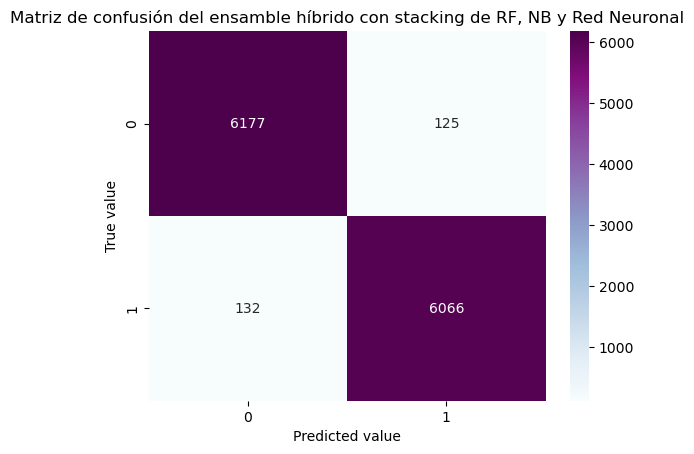

In [57]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

confussionMatrix = confusion_matrix(y_test,y_pred)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del ensamble híbrido con stacking de RF, NB y Red Neuronal")
plt.show()

Mostramos las distintas métricas

In [59]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.97944
Recall: 0.978702807357212
Precision: 0.979809400743014
f1 score: 0.9792557914278796


Realizamos las predicciones de los datos que vamos a submitear a kaggle

In [60]:
y_pred = stackingEnsamble.predict(criticsTest["review"])

269/269 [==============================] - 0s 2ms/step


Agrupamos en el dataframe los valores predichos decodeados con el label encoder

In [61]:
kaggleResult = criticsTest.copy()
kaggleResult.drop(columns=["review"], inplace=True)

kaggleResult["sentimiento"] = labelEncoder.inverse_transform(y_pred)

kaggleResult.head(2)

,ID,sentimiento
0,60000,negativo
1,60001,negativo


Para exportar a Kaggle exportamos el csv. El `runNumber` es sólo un número que ponemos para no pisar los submits

In [62]:
kaggleResult.to_csv(f"submit_{runNumber}_grupo16_gpwin_ensamble.csv", index=False)

Guardamos una serialización del modelo

In [64]:
filename = f'./ensamble_{runNumber}.joblib'
modelInfo = {'model': stackingEnsamble}

joblib.dump(modelInfo, filename)

['./ensamble_28.joblib']